# Соревнование на Kaggle: teta_ml_2_2025  
## Предсказание числа дней занятости аренды недвижимости  

#### Overview  
Соревнование в рамках курса от МТС. Задача: предсказание дней занятости (или простоя) аренды недвижимости.  

#### Description  
Соревнование по задаче регрессии  

#### Evaluation  
Оценка по метрике MSE  

### Dataset Description  

#### Files  
train.csv - the training set  
test.csv - the test set  
sample_submission.csv - a sample submission file in the correct format  

#### Columns  

| Column            | Description |
|------------------|-------------|
| name            | название объекта |
| _id             | уникальный идентификатор |
| host_name       | имя владельца или хоста, который предоставляет жилье |
| location_cluster | кластеризация местоположений (например, группировка объектов по районам или зонам). |
| location        | описание местоположения объекта |
| lat, lon       | широта и долгота местоположения объекта. |
| type_house      | тип жилья |
| sum            | общая стоимость аренды или сумма за определенный период. |
| min_days       | минимальное количество дней для бронирования объекта. |
| amt_reviews    | количество отзывов, оставленных для данного объекта. |
| last_dt        | дата последнего отзыва или последнего бронирования. |
| avg_reviews    | средний рейтинг или среднее количество отзывов за определенный период. |
| total_host     | общее количество объектов, принадлежащих одному хосту |
| target         | целевая переменная |



## Intro
### Описание финального решения:
1) **как обработали данные**;
   
   - Заполнил пропуски - медианным значением для непрерывных переменных и значениями между значениями слева и справа для дат;
   - Категориальные признаки закодировал с помощью CatBoost Encoder (Target Encoding);
   - Скалирование непрерывных переменных не показало достаточного прироста в качестве скора - скорее, модель наоборот выдавала более смещенные предикты, чем ожидалось.
   - Сгенерировал достаточно много собственных признаков (смотреть ноутбук далее);
   - Отдельное внимание уделил нелинейному преобразованию признаков, в том числе и собственных признаков - квадраты и логарифмы показали значимость практически при всех методах оценки значимости переменных в модели.

3) **какой алгоритм вы выбрали**;
   
   - Использовал CatBoost для задачи регрессии с собственным подбором гиперпараметров как BaseLine модель;
   - Использовал CatBoost для задачи регрессии с побором параметров с помощью Hyperopt и 10-Fold KFold Cross-Validation - Final модель.

5) **какие особенности использовали при его обучении**;
   
   - Пробовал передавать категориальные признаки как в сам алгоритм, так и кодировать отдельно - кодировка с помощью CatBoost Encoding отдельно показала более хорошие результаты;
   - Достаточно много потратил времени на ручной подбор глубины деревьев - на удивление, как мне показалось, подобранные гиперпараметры не всегда давали лучший скор на Kaggle;

7) **как проводили валидацию алгоритма**.
   
   - 10-Fold KFold Cross-Validation в Final модели;
   - Использовал Hyperopt для подбора оптимальных гиперпараметров.

## Outro
### Описание вариантов по дальнейшему улучшению итогового подхода:

1) **идея №1, которая может улучшить метрику, как ее реализовать (что для этого нужно сделать)**;
   
   - **Feature Engeneering**
   - Больше времени уделить на feature engeneering - как показала практика, именно FE дает крайне значимый прирост в значениях метрики;
   - Можно достаточно плотно поработать с координатными признаками;
   - Можно много времени уделить на агрерированные показатели по категориям;

2) **идея №2, которая может улучшить метрику, как ее реализовать (что для этого нужно сделать)**;
   
   - **Ансамблирование**
   - В ходе работы пробовал обучить 3 бустинговых базовых алгоритма (XGBoost, LightGBM и CatBoost), а далее использовать мета-модель (линейная регрессия) для получения весов для каждого столбца-вектора предиктов - подход интересный, но выдавал результаты хуже, чем правильно затюненный CatBoost;
   - В целом, считаю, что можно попробовать сделать следующее - обучить не 3 алгоритма, а более 5, причем взять не просто больше вариаций бустинга, а добавить еще алгоритмы с достаточно нестабильными (неробастными) предиктами. Далее, заблендить данные алгоритмы и посмотреть уже на результат такого объединения;
   - В любом случае, кажется, что даже мой первоначальный подход имел место быть, но требовал доработок (более качественный подбор гиперпараметров для базовых алгоритмов, кросс-валидация и прочее).

     
3) **идея №3, которая может улучшить метрику, как ее реализовать (что для этого нужно сделать)**.
   
   - **Обеспечить робастность скора по RMSE**
   - Adversarial Validation / Kolmogorov-Smirnov Test - оценка различий в распределениях, так как продакшн-ready модель должна иметь четкий мониторинг по этой части;
   - Подумать над Out-of-Time Sample

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import zscore

import category_encoders as ce  

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


In [4]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [5]:
test

,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host
0,Amazing 4 Bedrooms 4 Bathrooms sleeps 9,199147185,Lou,Brooklyn,Sunset Park,40.66468,-73.99785,Entire home/apt,399,1,0,NaN,NaN,5
1,Super Spacious room in Brooklyn,259427246,Nelly,Brooklyn,Bedford-Stuyvesant,40.67880,-73.92722,Private room,43,1,4,2019-06-10,2.00,3
2,Stunning 1-Bedroom NYC Apartment on the River!,30283594,Kara,Manhattan,Hell's Kitchen,40.76170,-73.99762,Entire home/apt,275,30,2,2017-09-17,0.08,121
3,Large Bushwick Bedroom in Newly Renovated Aprt...,51985960,Jonathan,Brooklyn,Williamsburg,40.70748,-73.92835,Private room,40,3,0,NaN,NaN,2
4,Bedroom in Crown Heights,68039772,Celeste,Brooklyn,Crown Heights,40.67249,-73.95564,Private room,55,4,1,2018-12-02,0.14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12219,Comfortable stay,15344412,Abe,Staten Island,New Springville,40.58091,-74.15485,Private room,52,1,74,2019-06-25,3.34,3
12220,"Spacious 1 bedroom in Flatbush, Brooklyn, NY.",107090465,Linwood,Brooklyn,East Flatbush,40.63835,-73.94621,Entire home/apt,125,3,2,2019-05-10,0.61,1
12221,Gramercy~Reno New 1BR-Sleeps 4~,2119276,Host,Manhattan,Gramercy,40.73568,-73.98062,Entire home/apt,150,30,2,2015-08-07,0.03,39
12222,Bright room in 2BR apt in Nolita!,24170584,Lauren,Manhattan,Little Italy,40.71959,-73.99604,Private room,99,2,2,2015-10-06,0.04,2


## Feature Engeenering

#### Работа с пропусками

In [8]:
# Заменим
# Удаляем строки с пропусками в last_dt
train = train.dropna(subset=['last_dt'])
# test = test.dropna(subset=['last_dt'])

# Заменяем пропуски в avg_reviews на медиану
train['avg_reviews'].fillna(train['avg_reviews'].median(), inplace=True)
test['avg_reviews'].fillna(test['avg_reviews'].median(), inplace=True)

# Удаляем строки с пропусками в name и host_name
train = train.dropna(subset=['name', 'host_name'])
# test = test.dropna(subset=['name', 'host_name'])

In [9]:
n_clusters = train["location_cluster"].nunique()
print(f"Число уникальных кластеров в location_cluster: {n_clusters}")

Число уникальных кластеров в location_cluster: 5


### Попробуем что-то в упрощенной форме придумать, используя DBSCAN

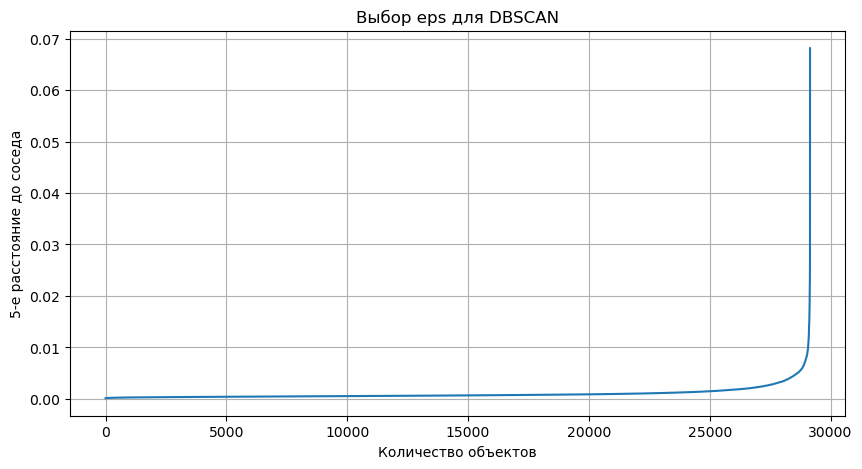

In [11]:
# Подбор eps по методу локтя
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(train[['lat', 'lon']])
distances, indices = neighbors_fit.kneighbors(train[['lat', 'lon']])
distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.xlabel("Количество объектов")
plt.ylabel(f"{min_samples}-е расстояние до соседа")
plt.title("Выбор eps для DBSCAN")
plt.grid()
plt.show()

In [12]:
# # kmeans - NO!

# from sklearn.cluster import KMeans

# n_clusters = 1000 # feature space quantization??????

eps = 0.03 # так работает )
# Применяем DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=5)
train['location_cluster_dbscan'] = dbscan.fit_predict(train[['lat', 'lon']])
test['location_cluster_dbscan'] = dbscan.fit_predict(test[['lat', 'lon']])  # Предсказания для теста



# Добавляем координаты центроидов для DBSCAN типа среднего по кластерам
train['cluster_lat_centroid'] = train.groupby('location_cluster_dbscan')['lat'].transform('mean')
train['cluster_lon_centroid'] = train.groupby('location_cluster_dbscan')['lon'].transform('mean')

test['cluster_lat_centroid'] = test.groupby('location_cluster_dbscan')['lat'].transform('mean')
test['cluster_lon_centroid'] = test.groupby('location_cluster_dbscan')['lon'].transform('mean')

# Добавляем расстояние до центра кластера
train['dist_to_cluster_center'] = ((train['lat'] - train['cluster_lat_centroid'])**2 + 
                                   (train['lon'] - train['cluster_lon_centroid'])**2) ** 0.5
test['dist_to_cluster_center'] = ((test['lat'] - test['cluster_lat_centroid'])**2 + 
                                  (test['lon'] - test['cluster_lon_centroid'])**2) ** 0.5

# Проверим количество кластеров
num_clusters = len(set(train['location_cluster_dbscan'])) - (1 if -1 in train['location_cluster_dbscan'] else 0)
print(f"DBSCAN нашел {num_clusters} кластеров")

DBSCAN нашел 5 кластеров


### Тоже из части работы с координатами

In [14]:
from geopy.distance import geodesic

# Создадим центральную точку (0, 0)
central_point = (0, 0)

# Рассчитываем расстояние от каждой точки до центральной точки (0, 0)
train['distance_to_central_point'] = train.apply(lambda row: geodesic((row['lat'], row['lon']), central_point).km, axis=1)
test['distance_to_central_point'] = test.apply(lambda row: geodesic((row['lat'], row['lon']), central_point).km, axis=1)

#### Широта и долгота - помучаем их (на удивление, профит действительно был)

In [16]:
# Добавим новые признаки
train['lat_lon_product'] = train['lat'] * train['lon']
train['lat_lon_ratio'] = train['lat'] / train['lon']
train['lat_lon_difference'] = train['lat'] - train['lon']
train['lat_lon_sum'] = train['lat'] + train['lon']
train['lat_squared'] = train['lat'] ** 2
train['lon_squared'] = train['lon'] ** 2
train['lat_lon_squared_product'] = (train['lat'] * train['lon']) ** 2
train['lat_lon_squared_sum'] = train['lat']**2 + train['lon']**2

test['lat_lon_product'] = test['lat'] * test['lon']
test['lat_lon_ratio'] = test['lat'] / test['lon']
test['lat_lon_difference'] = test['lat'] - test['lon']
test['lat_lon_sum'] = test['lat'] + test['lon']
test['lat_squared'] = test['lat'] ** 2
test['lon_squared'] = test['lon'] ** 2
test['lat_lon_squared_product'] = (test['lat'] * test['lon']) ** 2
test['lat_lon_squared_sum'] = test['lat']**2 + test['lon']**2

### Даты

In [18]:
train['last_dt'] = pd.to_datetime(train['last_dt'])
test['last_dt'] = pd.to_datetime(test['last_dt'])

train['last_dt_date'] = train['last_dt'].dt.date
test['last_dt_date'] = test['last_dt'].dt.date

In [19]:
import holidays

# Создаём список праздников для США в 2019 году
us_holidays = holidays.US(years=[2011, 2019])

# Функция для получения названия праздника
def get_holiday_name(date):
    return us_holidays.get(date) if date in us_holidays else "No Holiday"

# Функция для биннинга времени суток
def assign_time_of_day(hour):
    if 6 <= hour < 12:
        return "morning" 
    elif 12 <= hour < 18:
        return "afternoon"
    elif 18 <= hour < 24:
        return "evening" 
    else:
        return "night"

# столбцы для извлечения информации по дате
train['last_dt_month'] = train['last_dt'].dt.month
train['last_dt_week'] = train['last_dt'].dt.isocalendar().week
train['last_dt_day_of_the_week'] = train['last_dt'].dt.dayofweek
train['last_dt_hour'] = train['last_dt'].dt.hour
train['last_dt_minute'] = train['last_dt'].dt.minute

# праздники для 'last_dt'
train["last_dt_holidays"] = train["last_dt"].apply(get_holiday_name)

# Бининг времени суток для 'last_dt'
train['last_dt_binning_by_part'] = train['last_dt_hour'].apply(assign_time_of_day)

# test
test['last_dt_month'] = test['last_dt'].dt.month
test['last_dt_week'] = test['last_dt'].dt.isocalendar().week
test['last_dt_day_of_the_week'] = test['last_dt'].dt.dayofweek
test['last_dt_hour'] = test['last_dt'].dt.hour
test['last_dt_minute'] = test['last_dt'].dt.minute

test["last_dt_holidays"] = test["last_dt"].apply(get_holiday_name)
test['last_dt_binning_by_part'] = test['last_dt_hour'].apply(assign_time_of_day)

#### Сезоны и кварталы

In [21]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def get_quarter(month):
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    else:
        return 4

# Применим функции к столбцам
train['season'] = train['last_dt_month'].apply(get_season)
train['quarter'] = train['last_dt_month'].apply(get_quarter)

test['season'] = test['last_dt_month'].apply(get_season)
test['quarter'] = test['last_dt_month'].apply(get_quarter)

### РАССТОЯНИЯ

In [23]:
from math import atan2, cos, radians, sin, sqrt


def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта расстояния от точки А до Б по прямой

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Дистанция по прямой с точностью до n_digits
    """

    lat1, lon1, lat2, lon2 = round(lat1, 6), round(lon1, 6), round(lat2, 6), round(lon2, 6)
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)

    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2

    return round(2 * 6372800 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)), n_digits)  # метры.сантиметры


def bearing_degree(lat1: float, lon1: float, lat2: float, lon2: float, n_digits: int = 0) -> float:
    """
        Функция для расчёта угла между прямой [((lat1, lon1), (lat2, lon2)), (нулевой мередиан)]

        :param lat1: Широта точки А
        :param lon1: Долгота точки А
        :param lat2: Широта точки Б
        :param lon2: Долгота точки Б
        :param n_digits: Округляем полученный ответ до n знака после запятой
        :return: Значение угла с точностью до n_digits
    """

    lat1, lon1 = np.radians(round(lat1, 6)), np.radians(round(lon1, 6))
    lat2, lon2 = np.radians(round(lat2, 6)), np.radians(round(lon2, 6))

    dlon = (lon2 - lon1)
    numerator = np.sin(dlon) * np.cos(lat2)
    denominator = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    theta = np.arctan2(numerator, denominator)
    theta_deg = (np.degrees(theta) + 360) % 360

    return round(theta_deg, n_digits)

In [24]:
# Рассчитываем для lat и lon

# Угол (bearing) для lat и lon относительно точки (0, 0)
train['bearing_degree_lat_lon_1'] = bearing_degree(train['lat'], train['lon'], 0, 0).values
test['bearing_degree_lat_lon_1'] = bearing_degree(test['lat'], test['lon'], 0, 0).values

train['bearing_degree_lat_lon_2'] = bearing_degree(0, 0, train['lat'], train['lon']).values
test['bearing_degree_lat_lon_2'] = bearing_degree(0, 0, test['lat'], test['lon']).values

# Расстояние (haversine) для lat и lon относительно точки (0, 0)
train['hav_dist_lat_lon_1'] = haversine_distance(train['lat'], train['lon'], 0, 0).values
test['hav_dist_lat_lon_1'] = haversine_distance(test['lat'], test['lon'], 0, 0).values

train['hav_dist_lat_lon_2'] = haversine_distance(0, 0, train['lat'], train['lon']).values
test['hav_dist_lat_lon_2'] = haversine_distance(0, 0, test['lat'], test['lon']).values

## НЕПРЕРЫВНЫЕ ПЕРЕМЕННЫЕ

In [26]:
# Логарифмические преобразования
for feature in ['sum', 'avg_reviews', 'total_host', 'amt_reviews', 'min_days']:
    train[f'{feature}_log'] = np.log1p(train[feature])
    test[f'{feature}_log'] = np.log1p(test[feature])


# Квадраты переменных
for feature in ['sum', 'avg_reviews', 'total_host', 'amt_reviews', 'min_days']:
    train[f'{feature}_squared'] = train[feature] ** 2
    test[f'{feature}_squared'] = test[feature] ** 2
    
    train[f'{feature}_sqrt'] = np.sqrt(train[feature].clip(lower=0))
    test[f'{feature}_sqrt'] = np.sqrt(test[feature].clip(lower=0))


# Тригонометрия - опять же, скорее, тут есть сезонность

for feature in ['sum', 'avg_reviews', 'total_host', 'amt_reviews', 'min_days']:
    train[f'{feature}_sin'] = np.sin(train[feature])
    test[f'{feature}_sin'] = np.sin(test[feature])

# ЛОГАРИФМЫ
for feature in ['sum_sqrt', 'avg_reviews_sqrt', 'total_host_sqrt', 'amt_reviews_sqrt', 'min_days_sqrt']:
    train[f'{feature}_log'] = np.log1p(train[feature])
    test[f'{feature}_log'] = np.log1p(test[feature])


##### Квантили - показало, что особо смысла нет, но попробую

In [28]:
features = ['sum', 'avg_reviews', 'total_host', 'amt_reviews', 'min_days']

for feature in features:
    for q in [0.25, 0.50, 0.75]:
        train[f'{feature}_{int(q*100)}'] = train[feature].quantile(q)
        test[f'{feature}_{int(q*100)}'] = test[feature].quantile(q)

#### Агрегации

In [30]:
# Группируем по кластеру и вычисляем среднюю цену для каждого кластера
cluster_avg_sum = train.groupby('location_cluster')['sum'].transform('mean')

# Создаем новый столбец с соотношением цены объекта к средней цене в его кластере
train['sum_to_cluster_avg'] = train['sum'] / cluster_avg_sum


cluster_avg_sum_test = test.groupby('location_cluster')['sum'].transform('mean')
test['sum_to_cluster_avg'] = test['sum'] / cluster_avg_sum_test

In [31]:
def add_sum_stats(df, ref_df):
    """
    Добавляет агрегированные статистики по `sum` на основе `location_cluster` и `last_dt`,
    а также вычисляет дополнительные признаки: логарифмы, квадраты и синусы статистик.

    :param df: DataFrame, куда добавляем статистики.
    :param ref_df: DataFrame, на основе которого считаем статистики.
    """
    # Агрегируем статистики для `sum` в ref_df
    sum_stats = ref_df.groupby(['location_cluster', 'last_dt']).agg(
        sum_count=('sum', 'size'),
        sum_mean=('sum', 'mean'),
        sum_median=('sum', 'median'),
        sum_total=('sum', 'sum')
    ).reset_index()

    # Объединяем df с агр стат
    df = df.merge(sum_stats, on=['location_cluster', 'last_dt'], how='left')

    # Добавляем логарифм статистик
    df['sum_count_log'] = np.log1p(df['sum_count'])
    df['sum_mean_log'] = np.log1p(df['sum_mean'])
    df['sum_median_log'] = np.log1p(df['sum_median'])
    df['sum_total_log'] = np.log1p(df['sum_total'])

    # Добавляем квадраты статистик
    df['sum_count_squared'] = df['sum_count'] ** 2
    df['sum_mean_squared'] = df['sum_mean'] ** 2
    df['sum_median_squared'] = df['sum_median'] ** 2
    df['sum_total_squared'] = df['sum_total'] ** 2

    # Добавляем синусы статистик
    df['sum_count_sin'] = np.sin(df['sum_count'])
    df['sum_mean_sin'] = np.sin(df['sum_mean'])
    df['sum_median_sin'] = np.sin(df['sum_median'])
    df['sum_total_sin'] = np.sin(df['sum_total'])

    return df

# Добавляем статистики для train и test
train = add_sum_stats(train, train)
test = add_sum_stats(test, train) 

In [32]:
# Считаем статистики по всем данным (train + test)
id_stats_all = pd.concat([train, test]).groupby('_id').agg(
    id_frequency=('_id', 'count'),
    id_mean_sum=('sum', 'mean'),
    id_median_sum=('sum', 'median'),
    id_sum=('sum', 'sum')
).reset_index()

# Мерджим статистики
train = train.merge(id_stats_all, on='_id', how='left')
test = test.merge(id_stats_all, on='_id', how='left')

# Обрабатываем числовые фичи
numeric_cols = test.select_dtypes(include=['float64', 'int64']).columns
test[numeric_cols] = test[numeric_cols].fillna(test[numeric_cols].median())

# Обрабатываем категориальные фичи
cat_cols = test.select_dtypes(include=['object']).columns
for col in cat_cols:
    test[col] = test[col].fillna(test[col].mode()[0])

In [33]:
# что-то на лекции было про это
train['no_reviews'] = (train['amt_reviews'] == 0).astype(int)
test['no_reviews'] = (test['amt_reviews'] == 0).astype(int)

In [34]:
# Средний рейтинг всех объектов одного хоста

train['host_name_avg_rating'] = train.groupby('host_name')['avg_reviews'].transform('mean')
test['host_name_avg_rating'] = test.groupby('host_name')['avg_reviews'].transform('mean')

### Ещё несколько идей

In [36]:
# Группируем по локации и вычисляем среднее значение target
location_target_mean = train.groupby('location')['target'].mean().to_dict()

# Кодируем локации в train и test
train['location_encoded_by_cluster'] = train['location'].map(location_target_mean)
test['location_encoded_by_cluster'] = test['location'].map(location_target_mean)

# Группируем по локации и считаем статистики на train
location_stats = train.groupby('location')['sum'].agg(['mean', 'median', 'sum']).reset_index()

# Переименовываем
location_stats.columns = ['location', 'mean_sum_by_cluster', 'median_sum_by_cluster', 'total_sum_by_cluster']

# Объединяем train и test с рассчитанными статистиками
train = train.merge(location_stats, on='location', how='left')
test = test.merge(location_stats, on='location', how='left')

# Если в test есть локации, которых нет в test - заполним средними
test[['mean_sum_by_cluster', 'median_sum_by_cluster', 'total_sum_by_cluster']] = \
    test[['mean_sum_by_cluster', 'median_sum_by_cluster', 'total_sum_by_cluster']].fillna(
        train[['mean_sum_by_cluster', 'median_sum_by_cluster', 'total_sum_by_cluster']].mean())

# квадраты
train['mean_sum_squared_by_cluster'] = train['mean_sum_by_cluster'] ** 2
train['median_sum_squared_by_cluster'] = train['median_sum_by_cluster'] ** 2
train['total_sum_squared_by_cluster'] = train['total_sum_by_cluster'] ** 2

test['mean_sum_squared_by_cluster'] = test['mean_sum_by_cluster'] ** 2
test['median_sum_squared_by_cluster'] = test['median_sum_by_cluster'] ** 2
test['total_sum_squared_by_cluster'] = test['total_sum_by_cluster'] ** 2

# логарифмы
train['mean_sum_log_by_cluster'] = np.log1p(train['mean_sum_by_cluster'])
train['median_sum_log_by_cluster'] = np.log1p(train['median_sum_by_cluster'])
train['total_sum_log_by_cluster'] = np.log1p(train['total_sum_by_cluster'])

test['mean_sum_log_by_cluster'] = np.log1p(test['mean_sum_by_cluster'])
test['median_sum_log_by_cluster'] = np.log1p(test['median_sum_by_cluster'])
test['total_sum_log_by_cluster'] = np.log1p(test['total_sum_by_cluster'])

### Даты

In [38]:
# я их до этого преобразовал?
train['last_dt'] = pd.to_datetime(train['last_dt'], errors='coerce')
test['last_dt'] = pd.to_datetime(test['last_dt'], errors='coerce')

# Текущая дата
current_date = pd.to_datetime('today')

# Разница между текущей датой и датой последнего отзыва (в днях)
train['days_since_last_review'] = (current_date - train['last_dt']).dt.days
test['days_since_last_review'] = (current_date - test['last_dt']).dt.days


# train
train['weeks_since_last_review'] = (current_date - train['last_dt']).dt.days // 7
train['months_since_last_review'] = (current_date - train['last_dt']).dt.days // 30
train['last_review_frequency'] = train.groupby('host_name')['last_dt'].diff().dt.days
train['last_review_frequency_log'] = np.log1p(train['last_review_frequency'])
train['is_long_since_last_review'] = (train['last_dt'] < current_date - pd.Timedelta(days=180)).astype(int)

# test
test['weeks_since_last_review'] = (current_date - test['last_dt']).dt.days // 7
test['months_since_last_review'] = (current_date - test['last_dt']).dt.days // 30
test['last_review_frequency'] = test.groupby('host_name')['last_dt'].diff().dt.days


train['last_review_frequency_log'] = np.log1p(train['last_review_frequency'])
test['last_review_frequency_log'] = np.log1p(test['last_review_frequency'])


test['is_long_since_last_review'] = (test['last_dt'] < current_date - pd.Timedelta(days=180)).astype(int)

In [39]:
train['last_review_frequency'].fillna(train['last_review_frequency'].median(), inplace=True)
test['last_review_frequency'].fillna(test['last_review_frequency'].median(), inplace=True)

In [40]:
train['last_dt'] = pd.to_datetime(train['last_dt']).values.astype('int64') // 10**9
test['last_dt'] = pd.to_datetime(test['last_dt']).values.astype('int64') // 10**9

In [41]:
# заполнение пропусков ближайшими значениями (forward fill и backward fill)
train['last_dt'] = train['last_dt'].fillna(method='ffill').fillna(method='bfill')
test['last_dt'] = test['last_dt'].fillna(method='ffill').fillna(method='bfill')

In [42]:
train_missing = train.isnull().sum()
test_missing = test.isnull().sum()

# Выводим
print("Пропуски в train:\n", train_missing[train_missing > 0])
print("\nПропуски в test:\n", test_missing[test_missing > 0])

Пропуски в train:
 last_review_frequency_log    18393
dtype: int64

Пропуски в test:
 last_dt_week                   2550
location_encoded_by_cluster       1
days_since_last_review         2550
weeks_since_last_review        2550
months_since_last_review       2550
last_review_frequency_log      9752
dtype: int64


In [43]:
# Заполнение пропусков для train
train['last_review_frequency_log'] = train['last_review_frequency_log'].fillna(train['last_review_frequency_log'].median())

# Заполнение пропусков для test
# Для числовых столбцов пропуски заполню медианой
numerical_columns = [
    'sum_count', 'sum_mean', 'sum_median', 'sum_total', 
    'sum_count_log', 'sum_mean_log', 'sum_median_log', 'sum_total_log', 
    'sum_count_squared', 'sum_mean_squared', 'sum_median_squared', 
    'sum_total_squared', 'sum_count_sin', 'sum_mean_sin', 'sum_median_sin', 
    'sum_total_sin', 'last_review_frequency_log'
]

test[numerical_columns] = test[numerical_columns].fillna(test[numerical_columns].median())

In [44]:
train_missing = train.isnull().sum()
test_missing = test.isnull().sum()

# Выводим
print("Пропуски в train:\n", train_missing[train_missing > 0])
print("\nПропуски в test:\n", test_missing[test_missing > 0])

Пропуски в train:
 Series([], dtype: int64)

Пропуски в test:
 last_dt_week                   2550
location_encoded_by_cluster       1
days_since_last_review         2550
weeks_since_last_review        2550
months_since_last_review       2550
dtype: int64


In [45]:
# Замена пропусков на медиану
numerical_columns = [
    "days_since_last_review", "weeks_since_last_review", "months_since_last_review", "location_encoded_by_cluster", "last_dt_week"
]

for col in numerical_columns:
    test[col] = test[col].fillna(test[col].median())

In [46]:
# Выбираем только числовые столбцы
train_numeric = train.select_dtypes(include=[np.number])
test_numeric = test.select_dtypes(include=[np.number])

# Проверка на бесконечность (inf и -inf) в числовых данных
train_inf = np.isinf(train_numeric).sum()
test_inf = np.isinf(test_numeric).sum()

# Выводим количество инфинити значений по столбцам
print("Бесконечность в train:\n", train_inf[train_inf > 0])
print("\nБесконечность в test:\n", test_inf[test_inf > 0])

Бесконечность в train:
 last_review_frequency_log    181
dtype: Int64

Бесконечность в test:
 last_review_frequency_log    49
dtype: Int64


In [47]:
# Находим медиану для столбца 'last_review_frequency_log' в тренировочных и тестовых данных
median_train = train['last_review_frequency_log'][np.isfinite(train['last_review_frequency_log'])].median()
median_test = test['last_review_frequency_log'][np.isfinite(test['last_review_frequency_log'])].median()

# Заменяем бесконечные значения на медиану
train['last_review_frequency_log'] = np.where(np.isinf(train['last_review_frequency_log']), median_train, train['last_review_frequency_log'])
test['last_review_frequency_log'] = np.where(np.isinf(test['last_review_frequency_log']), median_test, test['last_review_frequency_log'])

# Проверим
train_inf_check = np.isinf(train['last_review_frequency_log']).sum()
test_inf_check = np.isinf(test['last_review_frequency_log']).sum()
print(f"Пропуски бесконечности в train после замены: {train_inf_check}")
print(f"Пропуски бесконечности в test после замены: {test_inf_check}")

Пропуски бесконечности в train после замены: 0
Пропуски бесконечности в test после замены: 0


In [48]:
numeric_features = [
    'lat', 'lon', 'sum', 'min_days', 'amt_reviews', 
    'avg_reviews', 
    'total_host', 
    'location_cluster_dbscan', 'cluster_lat_centroid', 
    'cluster_lon_centroid', 'dist_to_cluster_center', 'distance_to_central_point', 
    'lat_lon_product', 'lat_lon_ratio', 'lat_lon_difference', 'lat_lon_sum', 
    'lat_squared', 'lon_squared', 'lat_lon_squared_product', 'lat_lon_squared_sum', 
    'last_dt_month', 'last_dt_week', 'last_dt_day_of_the_week', 'last_dt_hour', 
    'last_dt_minute', 'quarter', 'bearing_degree_lat_lon_1', 'bearing_degree_lat_lon_2', 
    'hav_dist_lat_lon_1', 'hav_dist_lat_lon_2', 'sum_log', 'avg_reviews_log', 
    'total_host_log', 'amt_reviews_log', 'min_days_log', 'sum_squared', 'sum_sqrt', 
    'avg_reviews_squared', 'avg_reviews_sqrt', 'total_host_squared', 'total_host_sqrt', 
    'amt_reviews_squared', 'amt_reviews_sqrt', 'min_days_squared', 'min_days_sqrt', 
    'sum_sin', 'avg_reviews_sin', 'total_host_sin', 'amt_reviews_sin', 'min_days_sin', 
    'sum_sqrt_log', 'avg_reviews_sqrt_log', 'total_host_sqrt_log', 'amt_reviews_sqrt_log', 
    'min_days_sqrt_log', 'sum_25', 'sum_50', 'sum_75', 'avg_reviews_25', 'avg_reviews_50', 
    'avg_reviews_75', 'total_host_25', 'total_host_50', 'total_host_75', 'amt_reviews_25', 
    'amt_reviews_50', 'amt_reviews_75', 'min_days_25', 'min_days_50', 'min_days_75', 
    'sum_to_cluster_avg', 'sum_count', 'sum_mean', 'sum_median', 'sum_total', 'sum_count_log', 
    'sum_mean_log', 'sum_median_log', 'sum_total_log', 'sum_count_squared', 'sum_mean_squared', 
    'sum_median_squared', 'sum_total_squared', 'sum_count_sin', 'sum_mean_sin', 'sum_median_sin', 
    'sum_total_sin', 'id_frequency', 'id_mean_sum', 'id_median_sum', 'id_sum', 
    'days_since_last_review', 'weeks_since_last_review', 'months_since_last_review', 
    'last_review_frequency', 'last_review_frequency_log', 'is_long_since_last_review',
    'location_encoded_by_cluster', 'mean_sum_by_cluster', 'median_sum_by_cluster', 
    'total_sum_by_cluster', 'mean_sum_squared_by_cluster', 
    'median_sum_squared_by_cluster', 'total_sum_squared_by_cluster','mean_sum_log_by_cluster', 
    'median_sum_log_by_cluster', 
    'total_sum_log_by_cluster'
]


cat_features = [
    # 'name', 
    'host_name', 
    'location_cluster', 
    'location', 
    'type_house', 
    # 'last_dt_date', 
    'last_dt_holidays', 
    'last_dt_binning_by_part', 
    'season'
]

model_features = numeric_features + cat_features

#### Таргет-энкодинг

#### Несколько тестов показало, что таргет, который делается не при передаче параметров в catboost, а предварительно, работает лучше; скалирование признаков не показало особой значимости

In [51]:
target_enc = ce.CatBoostEncoder(cols=cat_features)
target_enc = target_enc.fit(train[cat_features], train['target'])

train = train.join(target_enc.transform(train[cat_features]).add_suffix('_cb'))
test = test.join(target_enc.transform(test[cat_features]).add_suffix('_cb'))

In [52]:
cat_features = [
    # 'name', 
    'host_name_cb', 
    'location_cluster_cb', 
    'location_cb', 
    'type_house_cb', 
    # 'last_dt_date', 
    'last_dt_holidays_cb', 
    'last_dt_binning_by_part_cb', 
    'season_cb'
]

model_features = numeric_features + cat_features

### CatBoost

In [54]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

X = train[model_features]
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,  # Используем X, чтобы разделить только признаки
    y,  # Целевая переменная
    test_size=0.2,
    stratify=train['target'],
    random_state=42
)

model_catboost = CatBoostRegressor(
    iterations=5000,
    learning_rate=0.01,
    depth=12,
    loss_function='RMSE',
    eval_metric='RMSE',
    # cat_features=cat_features,
    verbose=100
)

# Обучение модели
model_catboost.fit(X_train, y_train, 
                   eval_set=(X_test, y_test), 
                   early_stopping_rounds=50)

# Предсказание для тестовых данных
y_pred = model_catboost.predict(X_test)

# Важность признаков
feature_importance = model_catboost.get_feature_importance(prettified=True)
print(feature_importance)

# Получаем информацию о метрике с валидационного набора
best_score = model_catboost.get_best_score()

# best_score
print(best_score)

# RMSE
rmse = best_score['validation']['RMSE']
mse = rmse ** 2
print(f"MSE на валидации: {mse}")

### Немного не понял, зачем на семинаре использовали оценку через accuracy -> roc-auc, попробую обучить простой CatboostRegressor и оценить по RMSE

Базовый RMSE модели: 94.0127

Важность признаков (permutation importance):
                      feature  importance  permuted_rmse  percent_increase  \
107              host_name_cb   22.111013     116.123670         23.519187   
110             type_house_cb    2.345136      96.357794          2.494490   
91     days_since_last_review    2.310679      96.323337          2.457838   
93   months_since_last_review    1.884285      95.896943          2.004288   
4                 amt_reviews    1.674537      95.687195          1.781182   
..                        ...         ...            ...               ...   
20              last_dt_month   -0.033279      93.979378         -0.035399   
86              sum_total_sin   -0.039004      93.973654         -0.041488   
22    last_dt_day_of_the_week   -0.046921      93.965737         -0.049909   
77             sum_median_log   -0.047385      93.965273         -0.050403   
83              sum_count_sin   -0.154164      93.858493         -0

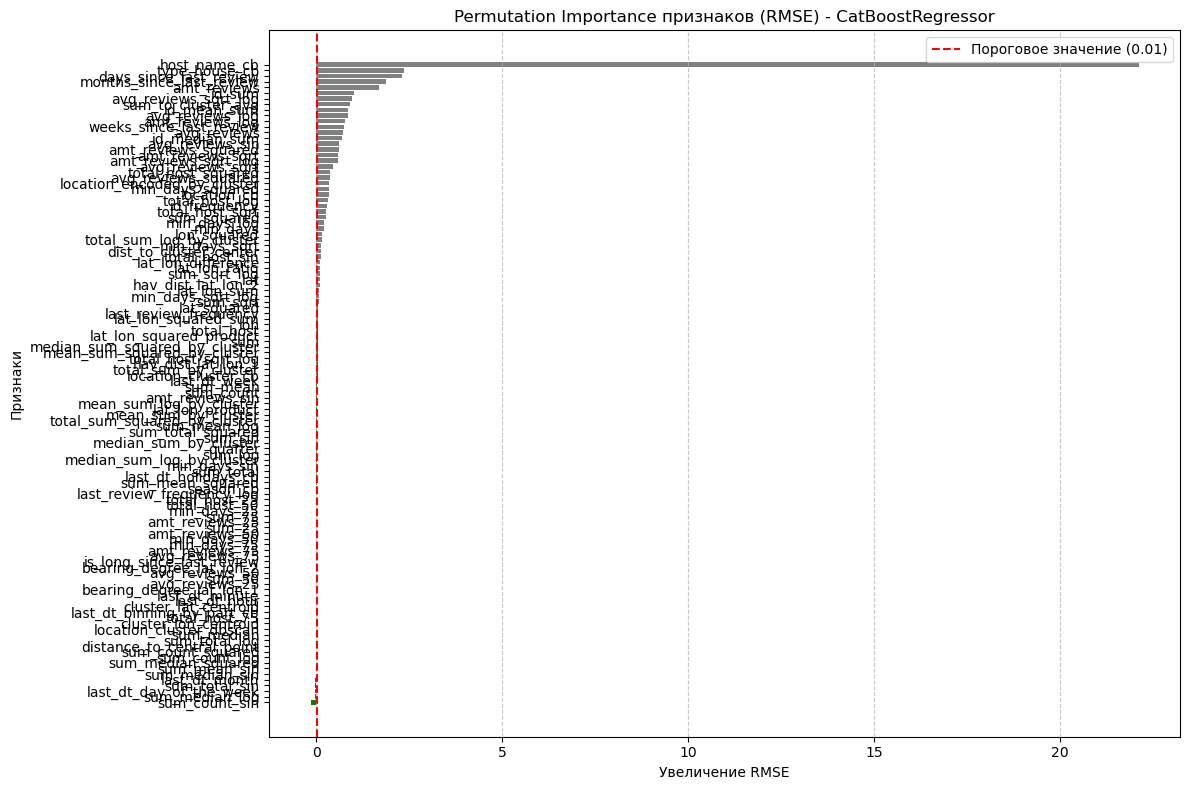

График важности признаков отображен.


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def permutation_importance(X, y, n_repeats=10, threshold=0.01, metric='rmse', 
                           n_top_features=None, plot=True, cat_features=None):
    """
    Реализация алгоритма важности на основе перестановок (permutation importance) для задачи регрессии
    с использованием CatBoostRegressor.

    Алгоритм оценивает важность признака путем перемешивания его значений и измерения ухудшения качества модели
    по метрике RMSE (Root Mean Squared Error).

    Параметры:
    ----------
    X : pandas DataFrame
        Датафрейм с признаками
    y : pandas Series или numpy array
        Целевая переменная (для регрессии)
    n_repeats : int, по умолчанию 10
        Количество повторений перемешивания для каждого признака
    threshold : float, по умолчанию 0.01
        Пороговое значение важности для отбора признаков (в единицах RMSE)
    metric : str, по умолчанию 'rmse'
        Метрика для оценки качества модели (поддерживается только 'rmse')
    n_top_features : int или None, по умолчанию None
        Количество лучших признаков для отбора. Если указано, threshold игнорируется
    plot : bool, по умолчанию True
        Создавать ли график важности признаков
    cat_features : list или None, по умолчанию None
        Список категориальных признаков, если таковые имеются.

    Возвращает:
    -----------
    pandas DataFrame
        Датафрейм с важностью признаков и обоснованием выбора
    list
        Список выбранных признаков
    """
    # Проверка корректности параметров
    if metric != 'rmse':
        raise ValueError("Для задачи регрессии поддерживается только метрика 'rmse'.")

    # Создаем копию данных
    X_copy = X.copy()

    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X_copy, y, test_size=0.3, random_state=42)

    # Создаем модель регрессии CatBoost
    model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        loss_function='RMSE',
        verbose=False,
        random_state=42
    )
    
    # Если заданы категориальные признаки, передаём их в fit
    if cat_features is not None:
        model.fit(X_train, y_train, cat_features=cat_features)
    else:
        model.fit(X_train, y_train)

    # Предсказания на тестовой выборке
    y_pred = model.predict(X_test)

    # Вычисляем базовую метрику RMSE
    baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Базовый RMSE модели: {baseline_rmse:.4f}")

    # Словари для хранения важности признаков и permuted RMSE
    feature_importance = {}
    feature_scores = {}

    # Для каждого признака
    for feature in X_test.columns:
        importance_scores = []
        permuted_scores = []

        # Повторяем n_repeats раз для стабильности оценки
        for _ in range(n_repeats):
            # Создаем копию тестовых данных
            X_test_permuted = X_test.copy()

            # Перемешиваем значения текущего признака
            X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature].values)

            # Предсказания с перемешанным признаком
            y_pred_permuted = model.predict(X_test_permuted)

            # Вычисляем RMSE после перемешивания
            permuted_rmse = np.sqrt(mean_squared_error(y_test, y_pred_permuted))
            permuted_scores.append(permuted_rmse)

            # Важность признака — насколько выросла ошибка RMSE
            importance = permuted_rmse - baseline_rmse
            importance_scores.append(importance)

        # Средняя важность по повторениям
        feature_importance[feature] = np.mean(importance_scores)
        feature_scores[feature] = np.mean(permuted_scores)

    # Создаем DataFrame с результатами
    importance_df = pd.DataFrame({
        'feature': list(feature_importance.keys()),
        'importance': list(feature_importance.values()),
        'permuted_rmse': list(feature_scores.values())
    }).sort_values('importance', ascending=False)

    # Добавляем процентное увеличение RMSE по сравнению с базовым значением
    importance_df['percent_increase'] = (importance_df['importance'] / baseline_rmse) * 100

    # Добавляем обоснование выбора
    def get_justification(row):
        if row['importance'] <= 0:
            return "Признак не влияет на качество модели или его перемешивание улучшает модель"
        elif row['percent_increase'] < 1:
            return "Незначительное влияние на модель (менее 1% увеличения RMSE)"
        elif row['percent_increase'] < 5:
            return "Умеренное влияние на модель (1-5% увеличения RMSE)"
        elif row['percent_increase'] < 10:
            return "Существенное влияние на модель (5-10% увеличения RMSE)"
        else:
            return "Критически важный признак (более 10% увеличения RMSE)"

    importance_df['justification'] = importance_df.apply(get_justification, axis=1)

    # Определяем, какие признаки выбрать
    if n_top_features is not None:
        selected_features = importance_df.head(n_top_features)['feature'].tolist()
        importance_df['selected'] = importance_df['feature'].isin(selected_features)
    else:
        selected_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()
        importance_df['selected'] = importance_df['importance'] > threshold

    # Вывод результатов
    print("\nВажность признаков (permutation importance):")
    print(importance_df)

    print(f"\nВыбрано {len(selected_features)} признаков:")
    for feature in selected_features:
        row = importance_df[importance_df['feature'] == feature].iloc[0]
        print(f"- {feature}: важность = {row['importance']:.4f}, "
              f"увеличение RMSE = {row['percent_increase']:.2f}%, "
              f"обоснование: {row['justification']}")

    # Визуализация результатов - добавил такое еще
    if plot and not importance_df.empty:
        plt.figure(figsize=(12, 8))
        colors = ['green' if selected else 'gray' for selected in importance_df['selected']]
        sorted_df = importance_df.sort_values('importance')
        plt.barh(sorted_df['feature'], sorted_df['importance'], color=colors)
        if n_top_features is None:
            plt.axvline(x=threshold, color='red', linestyle='--',
                        label=f'Пороговое значение ({threshold})')
            plt.legend()
        plt.xlabel('Увеличение RMSE')
        plt.ylabel('Признаки')
        plt.title('Permutation Importance признаков (RMSE) - CatBoostRegressor')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        print("График важности признаков отображен.")

    return importance_df, selected_features

X_true = train[model_features]  
y_true = train['target'] 

importance_df, selected_features = permutation_importance(
    X_true, y_true, n_repeats=10, threshold=0.01, metric='rmse', cat_features=None
)

In [58]:
# почитать в Excel

importance_df.to_excel("importance_features.xlsx", index=False)

### Исключим только те признаки, которые оказывают негативные влияние на метрику

#### Несколько раз прогонял тест, немного разные результаты - в итоге сделаю следующее - исключу фичи, которые permutation importance счет как влияющие негативно, так и с отсутствием влияния на скоры

In [61]:
numeric_features = [
    "days_since_last_review",
    "months_since_last_review",
    "amt_reviews",
    "id_sum",
    "sum_to_cluster_avg",
    "avg_reviews_sqrt_log",
    "id_mean_sum",
    "weeks_since_last_review",
    "avg_reviews_log",
    "amt_reviews_log",
    "avg_reviews",
    "id_median_sum",
    "amt_reviews_sqrt_log",
    "amt_reviews_sqrt",
    "amt_reviews_squared",
    "avg_reviews_sin",
    "avg_reviews_sqrt",
    "avg_reviews_squared",
    "total_host_squared",
    "min_days_squared",
    "location_encoded_by_cluster",
    "total_host_log",
    "total_host_sqrt",
    "id_frequency",
    "sum_squared",
    "min_days_log",
    "min_days",
    "total_sum_log_by_cluster",
    "min_days_sqrt",
    "dist_to_cluster_center",
    "total_host_sin",
    "last_review_frequency",
    "lon_squared",
    "sum_sqrt_log",
    "lat_lon_sum",
    "lat_lon_ratio",
    "lat_lon_difference",
    "lat",
    "hav_dist_lat_lon_2",
    "sum_sqrt",
    "min_days_sqrt_log",
    "total_host",
    "lat_squared",
    "last_dt_week",
    "lat_lon_squared_sum",
    "lon",
    "sum_mean",
    "sum_count",
    "sum_sin",
    "sum",
    "mean_sum_squared_by_cluster",
    "median_sum_squared_by_cluster",
    "total_host_sqrt_log",
    "hav_dist_lat_lon_1",
    "sum_total_squared",
    "median_sum_log_by_cluster",
    "amt_reviews_sin",
    "quarter",
    "mean_sum_by_cluster",
    "total_sum_squared_by_cluster",
    "lat_lon_squared_product",
    "lat_lon_product"
]

cat_features = [
    "host_name_cb",
    "type_house_cb",
    "location_cb",
    "location_cluster_cb"
]

model_features = numeric_features + cat_features

In [62]:
test[model_features]

,days_since_last_review,months_since_last_review,amt_reviews,id_sum,sum_to_cluster_avg,avg_reviews_sqrt_log,id_mean_sum,weeks_since_last_review,avg_reviews_log,amt_reviews_log,...,amt_reviews_sin,quarter,mean_sum_by_cluster,total_sum_squared_by_cluster,lat_lon_squared_product,lat_lon_product,host_name_cb,type_house_cb,location_cb,location_cluster_cb
0,2140.0,71.0,0,1691,3.214828,0.611186,338.200000,305.0,0.536493,0.000000,...,0.000000,4,113.978541,7.052742e+08,9.054676e+06,-3009.098891,82.555697,110.812253,110.306275,105.275460
1,2120.0,70.0,4,124,0.346460,0.881374,41.333333,302.0,1.098612,1.609438,...,-0.756802,2,107.129797,6.171945e+10,9.043676e+06,-3007.270597,162.333672,116.669400,121.888650,105.275460
2,2751.0,91.0,2,18236,1.364925,0.249078,256.845070,393.0,0.076961,1.098612,...,0.909297,3,183.238258,4.604114e+10,9.097877e+06,-3016.268787,242.178334,110.812253,140.794086,109.443669
3,2140.0,71.0,0,78,0.322288,0.611186,39.000000,305.0,0.536493,0.000000,...,0.000000,4,139.749790,1.111842e+11,9.056710e+06,-3009.436829,91.749040,116.669400,78.481218,105.275460
4,2310.0,77.0,1,55,0.443147,0.317847,55.000000,330.0,0.131028,0.693147,...,0.841471,4,113.533543,1.173127e+10,9.047824e+06,-3007.960028,190.958545,116.669400,100.431066,105.275460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12219,2105.0,70.0,74,102,0.610232,1.039417,51.000000,300.0,1.467874,4.317488,...,-0.985146,2,58.666667,3.097600e+04,9.055714e+06,-3009.271294,87.238337,116.669400,72.667090,201.791850
12220,2151.0,71.0,2,125,1.007151,0.577189,125.000000,307.0,0.476234,1.098612,...,0.909297,2,87.756173,8.084355e+08,9.030337e+06,-3005.051963,114.668359,110.812253,178.122056,105.275460
12221,3523.0,117.0,2,7440,0.744505,0.159739,190.769231,503.0,0.029559,1.098612,...,0.909297,3,213.054726,1.833895e+09,9.082092e+06,-3013.650863,253.322279,110.812253,105.646873,109.443669
12222,3463.0,115.0,2,364,0.491373,0.182322,182.000000,494.0,0.039221,1.098612,...,0.909297,4,185.236111,1.778756e+08,9.078702e+06,-3013.088410,59.212585,116.669400,111.762580,109.443669


In [83]:
### проверю проблему пропусков, в моменте было необходимо

In [63]:
train_numeric = train.select_dtypes(include=[np.number])
test_numeric = test.select_dtypes(include=[np.number])

# Проверка на бесконечность
train_inf = np.isinf(train_numeric).sum()
test_inf = np.isinf(test_numeric).sum()

print("Бесконечность в train:\n", train_inf[train_inf > 0])
print("\nБесконечность в test:\n", test_inf[test_inf > 0])

# На пропуски
train_missing = train.isnull().sum()
test_missing = test.isnull().sum()

print("Пропуски в train:\n", train_missing[train_missing > 0])
print("\nПропуски в test:\n", test_missing[test_missing > 0])

Бесконечность в train:
 Series([], dtype: Int64)

Бесконечность в test:
 Series([], dtype: Int64)
Пропуски в train:
 Series([], dtype: int64)

Пропуски в test:
 Series([], dtype: int64)


In [65]:
# заполнение пропусков ближайшими значениями (forward fill и backward fill)
train['last_dt'] = train['last_dt'].fillna(method='ffill').fillna(method='bfill')
test['last_dt'] = test['last_dt'].fillna(method='ffill').fillna(method='bfill')

### Тестовый CatBoost

#### Закомментировал - ничего интересного не было, просто хорошая оценка

In [66]:
# from catboost import CatBoostRegressor
# from sklearn.model_selection import train_test_split

# # Определяем признаки и целевую переменную
# X = train[model_features]
# y = train['target']

# # Разделяем данные на train и validation
# X_train, X_test, y_train, y_test = train_test_split(
#     X,  # Используем X, чтобы разделить только признаки
#     y,  # Целевая переменная
#     test_size=0.2,
#     stratify=train['target'],
#     random_state=42
# )

# # Обучение CatBoost модели
# model_catboost = CatBoostRegressor(
#     iterations=5000,
#     learning_rate=0.01,
#     depth=10,
#     loss_function='RMSE',
#     eval_metric='RMSE',
#     # cat_features=cat_features,
#     verbose=100
# )

# # Обучение модели
# model_catboost.fit(X_train, y_train, 
#                    eval_set=(X_test, y_test), 
#                    early_stopping_rounds=50)

# # Предсказание для тестовых данных
# y_pred = model_catboost.predict(X_test)

# # Выводим важность признаков
# feature_importance = model_catboost.get_feature_importance(prettified=True)
# print(feature_importance)

# # Получаем информацию о метрике с валидационного набора
# best_score = model_catboost.get_best_score()

# # Посмотрим, как выглядит структура best_score
# print(best_score)

# # RMSE
# rmse = best_score['validation']['RMSE']
# mse = rmse ** 2
# print(f"MSE на валидации: {mse}")

### Кросс-валидация с 10 фолдами - Kfold CV CatBoost

#### Тут уже поинтереснее

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

X = train[model_features]
y = train['target']

# Количество фолдов
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Список для хранения ошибок
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n===== Fold {fold+1} =====")

    # Разбиваем данные
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Создаем и обучаем модель
    model = CatBoostRegressor(
        iterations=5000,
        learning_rate=0.01,
        depth=10,
        loss_function='RMSE',
        eval_metric='RMSE',
        verbose=100,
        l2_leaf_reg=4,
        random_state=42
    )
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

    # Оцениваем модель
    best_score = model.get_best_score()
    rmse = best_score['validation']['RMSE']
    rmse_scores.append(rmse)

# Средний RMSE по фолдам
print(f"\nСредний RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")


===== Fold 1 =====
0:	learn: 128.9395385	test: 129.1253547	best: 129.1253547 (0)	total: 54.2ms	remaining: 4m 31s
100:	learn: 102.6243129	test: 104.2841571	best: 104.2841571 (100)	total: 6.13s	remaining: 4m 57s
200:	learn: 95.3219210	test: 98.1370070	best: 98.1370070 (200)	total: 12.6s	remaining: 4m 59s
300:	learn: 92.3943431	test: 96.1431847	best: 96.1431847 (300)	total: 19.2s	remaining: 4m 59s
400:	learn: 90.6780675	test: 95.1933177	best: 95.1933177 (400)	total: 25.7s	remaining: 4m 54s
500:	learn: 89.3819098	test: 94.7254530	best: 94.7254530 (500)	total: 32.1s	remaining: 4m 48s
600:	learn: 88.2867575	test: 94.3758200	best: 94.3758200 (600)	total: 38.7s	remaining: 4m 43s
700:	learn: 87.2765020	test: 94.0997732	best: 94.0997732 (700)	total: 45.1s	remaining: 4m 36s
800:	learn: 86.3137239	test: 93.9267288	best: 93.9260464 (799)	total: 51.8s	remaining: 4m 31s
900:	learn: 85.3387568	test: 93.7489321	best: 93.7483393 (899)	total: 58.4s	remaining: 4m 25s
1000:	learn: 84.4096617	test: 93.6626

In [92]:
# Создаем DataFrame с предсказаниями
model_preds = model.predict(test[model_features])

predictions_catboost_df = pd.DataFrame({
    'index': test.index,
    'prediction': model_preds
})

# Сохраняем в CSV
predictions_catboost_df.to_excel('predictions.xlsx', index=False)

predictions_catboost_df

,index,prediction
0,0,178.050730
1,1,186.647248
2,2,334.221074
3,3,83.030646
4,4,102.853503
...,...,...
12219,12219,110.999140
12220,12220,115.034366
12221,12221,297.572613
12222,12222,5.136099


### HyperOpt

#### Подбирал параметры через HyperOpt + 5 сплитов KFold, это решение я и засабмитил на Kaggle

##### Считается +- 40 минут (по крайней мере, у меня), поэтому закомментировал в моменте, при желании можно опробовать (убираю комментарии, но расчета уже не видно будет)

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm

X = train[model_features]
y = train['target']

# Определяем пространство поиска гиперпараметров для CatBoost
space = {
    'iterations': hp.quniform('iterations', 1000, 5000, 500),  
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),     
    'depth': hp.quniform('depth', 4, 12, 1),                    
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),            
    'subsample': hp.uniform('subsample', 0.6, 1.0),         
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.6, 1.0)  
}

# Количество фолдов
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Определяем целевую функцию для Hyperopt
def objective(params):
    params['iterations'] = int(params['iterations'])
    params['depth'] = int(params['depth'])
    
    rmse_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostRegressor(
            iterations=params['iterations'],
            learning_rate=params['learning_rate'],
            depth=params['depth'],
            l2_leaf_reg=params['l2_leaf_reg'],
            subsample=params['subsample'],
            colsample_bylevel=params['colsample_bylevel'],
            loss_function='RMSE',
            eval_metric='RMSE',
            verbose=0,
            random_state=42
        )

        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=0)
        best_score = model.get_best_score()
        rmse = best_score['validation']['RMSE']
        rmse_scores.append(rmse)

    mean_rmse = np.mean(rmse_scores)
    hyperopt_pbar.update(1)  # Обновляем прогресс-бар
    return {'loss': mean_rmse, 'status': STATUS_OK, 'params': params}

# Количество итераций Hyperopt
n_iter_hyperopt = 30
hyperopt_pbar = tqdm(total=n_iter_hyperopt, desc="Hyperopt")

# Запускаем Hyperopt
trials = Trials()
start_time = time.time()

best_hyperopt = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=n_iter_hyperopt,
    trials=trials
)

hyperopt_pbar.close()

# Получаем лучшие параметры
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_params_hyperopt = trials.trials[best_trial_idx]['result']['params']
best_score_hyperopt = min([t['result']['loss'] for t in trials.trials])
time_hyperopt = time.time() - start_time

# Дополнительно: вывод графика динамики RMSE по итерациям - ВЫГЛЯДИТ ИНТЕРЕСНО
results_df = pd.DataFrame(
    [{'iteration': i, 'loss': t['result']['loss']} for i, t in enumerate(trials.trials)]
)
plt.figure(figsize=(10, 5))
plt.plot(results_df['iteration'], results_df['loss'], marker='o')
plt.xlabel("Итерация")
plt.ylabel("CV RMSE")
plt.title("Динамика CV RMSE в процессе Hyperopt")
plt.grid()
plt.show()

# Обучаем финальную модель с лучшими параметрами
best_model_hyperopt = CatBoostRegressor(
    iterations=best_params_hyperopt['iterations'],
    learning_rate=best_params_hyperopt['learning_rate'],
    depth=best_params_hyperopt['depth'],
    l2_leaf_reg=best_params_hyperopt['l2_leaf_reg'],
    subsample=best_params_hyperopt['subsample'],
    colsample_bylevel=best_params_hyperopt['colsample_bylevel'],
    loss_function='RMSE',
    eval_metric='RMSE',
    verbose=100,
    random_state=42
)
best_model_hyperopt.fit(X, y)

print(f"\nHyperopt завершен за {time_hyperopt:.2f} секунд")
print(f"Лучшие параметры: {best_params_hyperopt}")
print(f"Лучший CV RMSE: {best_score_hyperopt:.4f}")


In [ ]:
# Предсказания модели
y_pred = best_model_hyperopt.predict(X)

# Остатки (разница между истинными значениями и предсказанными)
residuals = y - y_pred

# Визуализация гистограммы остатков
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='dashed', linewidth=2) 
plt.xlabel("Остатки (y_true - y_pred)")
plt.ylabel("Частота")
plt.title("Гистограмма остатков модели CatBoost")
plt.grid()
plt.show()

In [ ]:
import scipy.stats as stats


# KS-тест для оценки нормальности остатков
D, p_value = stats.kstest(residuals, 'norm')

print(f"Statistic: {D}")
print(f"P-value: {p_value}")

In [ ]:
# Создаем DataFrame с предсказаниями
model_preds = best_model_hyperopt.predict(test[model_features])

predictions_catboost_df = pd.DataFrame({
    'index': test.index,
    'prediction': model_preds
})

# Сохраняем в CSV
predictions_catboost_df.to_excel('predictions.xlsx', index=False)

predictions_catboost_df